In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
nurse_df = pd.read_excel('./nurse_labelled_notes_gpt3.xlsx')
nurse_df = nurse_df.rename(columns={'report': 'nurse_reports', 'needs' : 'nurse_labels'})
gpt_df = pd.read_excel('./gpt3_labelled_notes.xlsx')
gpt_df = gpt_df.rename(columns={'report': 'gpt_reports', 'needs' : 'gpt_labels'})

/Users/isabel/anaconda3/envs/nlp/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [9]:
def notes_analysis(nurse_df, gpt_df, title, filename, remove_comment_notes = False):
    # put all labels together
    compare_df = pd.concat([gpt_df, nurse_df], axis=1)
    # step 1 - find number of 'problematic notes' i.e., notes that were not deemed to be classifiable 
    mask = compare_df[['comments']].isnull().any(axis=1)
    comment_df = compare_df.dropna(subset=['comments'])
    print(f"\n---------\nPercentage of problematic notes ~{round((len(comment_df) / len(compare_df)) * 100, 2)}%")

    # step 2 - clean full dataframe to remove any unwanted information
    if remove_comment_notes:
        compare_df = compare_df[mask]
    cleaned_df = compare_df.drop(columns=['nurse_reports', 'comments'])

    # step 3 - remove any nan values
    mask = cleaned_df.isnull().any(axis=1)
    print(f"\n---------\nRows Removed: {cleaned_df[mask]}")
    cleaned_df = cleaned_df.dropna()

    # step 4 - get the correct and incorrect values
    true_positive = cleaned_df[(cleaned_df['nurse_labels'] == 'met') & (cleaned_df['gpt_labels'] == 'met')].shape[0]
    true_negative = cleaned_df[(cleaned_df['nurse_labels'] == 'unmet') & (cleaned_df['gpt_labels'] == 'unmet')].shape[0]
    false_positive = cleaned_df[(cleaned_df['nurse_labels'] == 'met') & (cleaned_df['gpt_labels'] == 'unmet')].shape[0]
    false_negative = cleaned_df[(cleaned_df['nurse_labels'] == 'unmet') & (cleaned_df['gpt_labels'] == 'met')].shape[0]
    true_all = cleaned_df[cleaned_df['nurse_labels'] == cleaned_df['gpt_labels']].shape[0]
    false_all = cleaned_df[cleaned_df['nurse_labels'] != cleaned_df['gpt_labels']].shape[0]
    print(f"\n---------\nTrue Positive: {true_positive}, False Negative: {false_negative}")
    print(f"False Positive: {false_positive}, True Negative: {true_negative}")

    print(f"\n---------\nPercentage of correct notes ~{round((true_all / len(compare_df)) * 100, 2)}%\nPercentage of incorrect notes ~{round((false_all / len(compare_df)) * 100, 2)}%\n---------\n")


    # step 5 - create and display confusion matrix
    plt.figure(figsize=(16, 12))
    conf_matrix = confusion_matrix(cleaned_df['gpt_labels'], cleaned_df['nurse_labels'], labels=['met', 'unmet'])
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                display_labels=['met', 'unmet']).plot()
    plt.xlabel('Nurse Labels')
    plt.ylabel('GPT Labels')
    plt.title(title)
    plt.savefig(f"./graphs/{filename}.png")
    plt.show()



---------
Percentage of problematic notes ~6.67%

---------
Rows Removed:                                            gpt_reports gpt_labels nurse_labels
54   - Resident A had a peaceful night with no sign...        met          NaN
233  - Sarah experiencing increased difficulty with...      unmet          NaN

---------
True Positive: 137, False Negative: 166
False Positive: 8, True Negative: 287

---------
Percentage of correct notes ~70.67%
Percentage of incorrect notes ~29.0%
---------



<Figure size 1600x1200 with 0 Axes>

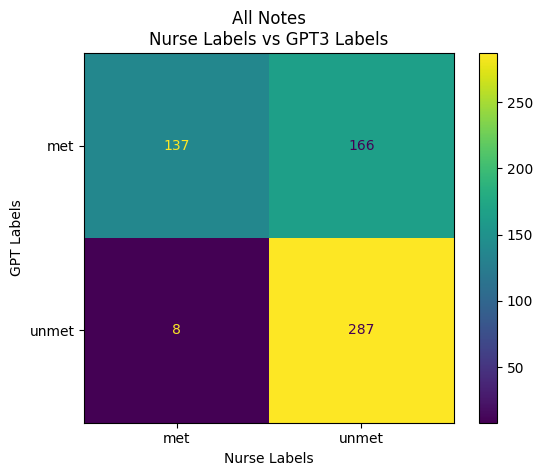

In [10]:
notes_analysis(nurse_df, gpt_df, 'All Notes\nNurse Labels vs GPT3 Labels', 'gpt3_all_notes', remove_comment_notes=False)


---------
Percentage of problematic notes ~6.67%

---------
Rows Removed: Empty DataFrame
Columns: [gpt_reports, gpt_labels, nurse_labels]
Index: []

---------
True Positive: 132, False Negative: 134
False Positive: 7, True Negative: 287

---------
Percentage of correct notes ~74.82%
Percentage of incorrect notes ~25.18%
---------



<Figure size 1600x1200 with 0 Axes>

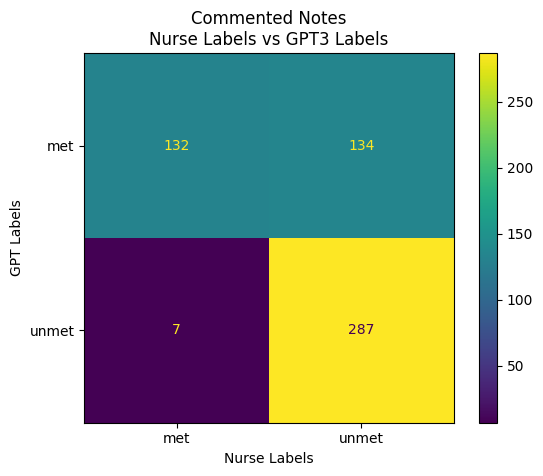

In [11]:
notes_analysis(nurse_df, gpt_df, 'Commented Notes\nNurse Labels vs GPT3 Labels', 'gpt3_comment_notes', remove_comment_notes=True)